In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import logging, sys, gc
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from frontiers_analysis import load_tissue

In [2]:
tissue="Stomach"
df = pd.read_csv(f"mca/mainTable_{tissue}.csv", index_col=0)
M = df.sum(0)
f = df.divide(M,1).mean(1)
O = df.apply(lambda x: (x>0).sum(), 1)

In [3]:
from methods import mazzolini as sampling
from methods import mazzolini_broad as poissonian_sampling
from methods import mazzolini_nbinom as nbinom_sampling
from methods import mazzolini_gaus as gaus_sampling

In [4]:
M_tilde = 25000

# Create models

In [5]:
method_delta = sampling(M=M, f=f)
method_pois = poissonian_sampling(M=M, f=f, M_tilde=M_tilde)
#method_nbinom = nbinom_sampling(M=M, f=f, M_tilde=M_tilde)
#method_gaus = gaus_sampling(M=M, f=f)

models = [method_delta, method_pois]
for method in models:
    print(method)
    method.run()

mazzolini
mazzolini_broad


## Zipf

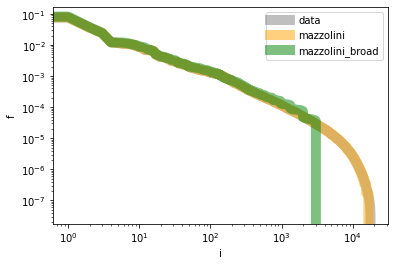

In [6]:
plt.plot(np.sort(f/f.sum())[::-1], lw=10, c="gray", alpha=0.5, label="data")
for model in models:
    plt.plot(model.get_f(), lw=10, alpha=0.5, label=model.name_, c=model.color_)

plt.xlabel("i")
plt.ylabel("f")

plt.xscale("log")
plt.yscale("log")

plt.legend()

## Heaps

mazzolini
mazzolini_broad


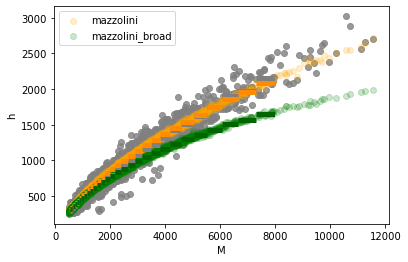

In [7]:
bins = np.logspace(np.log10(M.min()), np.log10(M.max()), 35)
#bins = np.linspace(M.min(), M.max(), 35)
    
h=df.apply(lambda x: (x>0).sum(),0)
plt.scatter(M, h, c="gray", alpha=0.8)
means, edges, _ = binned_statistic(M, h, bins=bins)
var, edges, _ = binned_statistic(M, h, statistic="std", bins=bins)
cnt, edges, _ = binned_statistic(M, h, statistic="count", bins=bins)
var = var*var
mask = cnt > 10
means = means[mask]
var = var[mask]
l_edges = (edges[:-1])[mask]
r_edges = (edges[1:])[mask]
plt.hlines(means, l_edges, r_edges, lw=5, color="gray", ls="--")

for model in models:
    print(model.name_)
    means, edges, _ = binned_statistic(M, model.get_h(), bins=bins)
    var, edges, _ = binned_statistic(M, model.get_h(), statistic="std", bins=bins)
    cnt, edges, _ = binned_statistic(M, model.get_h(), statistic="count", bins=bins)
    var = var*var
    mask = cnt > 10
    means = means[mask]
    var = var[mask]
    l_edges = (edges[:-1])[mask]
    r_edges = (edges[1:])[mask]

    plt.hlines(means, l_edges, r_edges, lw=5, color="dark"+model.color_, ls="--")

    plt.scatter(M, model.get_h(), alpha=0.2, c=model.color_, label=model.name_)
    
    model.hmean = means.copy()
    model.hvar = var.copy()
    model.cnt = cnt.copy()


plt.xlabel("M")
plt.ylabel("h")

plt.legend()

### Fluctuations

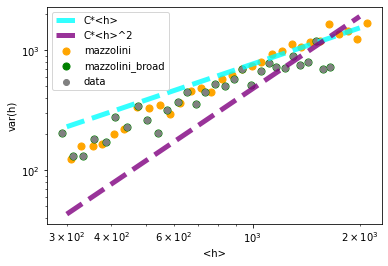

In [8]:
x = np.logspace(np.log10(300),np.log10(2000))

for model in models:
    plt.scatter(model.hmean, model.hvar, s=50, label=model.name_, c=model.color_)

plt.scatter(means, var, label="data", c="gray")
    
popt, pcov= curve_fit(lambda x, C: C*x, models[0].hmean, models[0].hvar)
plt.plot(x, popt[0]*x, lw=5, ls="--", c="cyan", alpha=0.8, label="C*<h>")

popt, pcov= curve_fit(lambda x, C: C*x*x, models[0].hmean, models[0].hvar)
plt.plot(x, popt[0]*x**2, lw=5, ls="--", c="purple", alpha=0.8, label ="C*<h>^2")
    
plt.xlabel("<h>")
plt.ylabel("var(h)")

plt.xscale("log")
plt.yscale("log")

plt.legend()

#plt.ylim(1e2,1e3)

## Abundance - frequency

In [ ]:
bins = np.logspace(np.log10(M.min()), np.log10(M.max()), 35)
#bins = np.linspace(M.min(), M.max(), 35)
    
plt.scatter(df.sum(1), df.divide(df.sum(0),1).mean(1), c="gray", alpha=0.8)


for model in models:
    print(model.name_)
    df_model = pd.DataFrame(data=model.table)
    plt.scatter(df_model.sum(1), df_model.divide(df_model.sum(0),1).mean(1), alpha=0.2, c=model.color_, label=model.name_)
    del df_model
    
plt.xlabel("a")
plt.ylabel("f")
plt.yscale("log")
plt.xscale("log")

plt.legend()

mazzolini
mazzolini_broad
Error in callback <function flush_figures at 0x7f200ac92ca0> (for post_execute):


## CV^2

In [9]:
for model in models:
    means = np.mean(model.table,0)
    mean = means[means>0]
    var = np.var(model.table,0)
    cv2 = var[means>0]/mean/mean
    plt.scatter(mean,cv2, alpha=0.5, label=model.name_,c=model.color_)

x = np.linspace(1e-4,1e2,10)
plt.plot(x,1/x, alpha=0.5, label="<>",c="gray", ls="--", lw=5)

    
plt.xscale("log")
plt.yscale("log")

plt.xlabel("<>")
plt.ylabel("CV^2")

plt.ylim(1e-2,1e5)
plt.xlim(5e-5,1e2)


plt.legend()

ERROR! Session/line number was not unique in database. History logging moved to new session 22


NotImplementedError: emit must be implemented by Handler subclasses

## U

In [ ]:
for model in models:
    plt.hist(model.get_O(), lw=10, ls="--", histtype="step", label=model.name_, color=model.color_, alpha=0.4)
    
plt.hist(O/O.sum(), color="gray", label="data")
plt.legend()

## Predicted occurrences

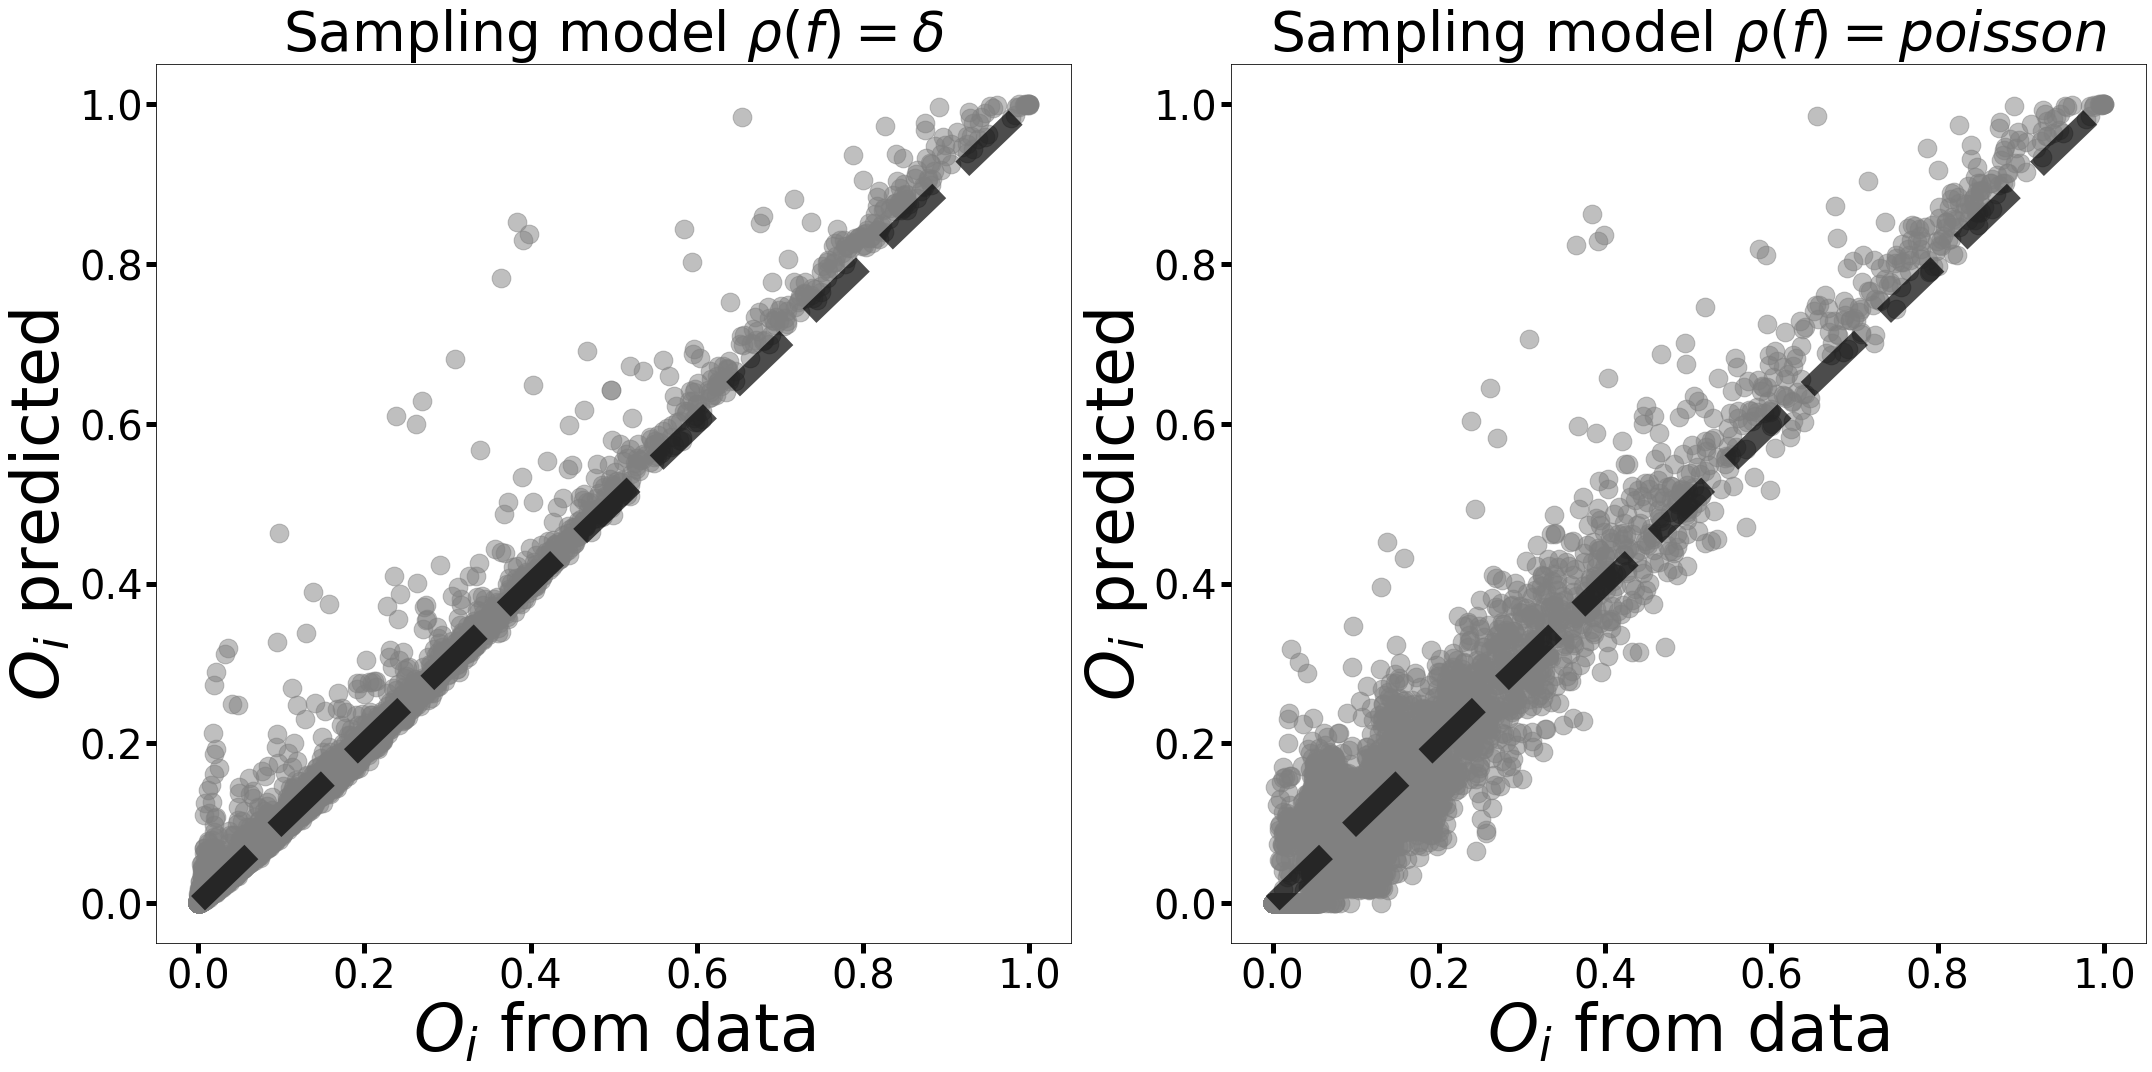

In [31]:
fig, axs = plt.subplots(1, len(models), figsize=(30, 15))

models[0].color_="gray"
models[1].color_="gray"
for model, ax in zip(models, axs):
    #ax.scatter(O/df.shape[1], model.get_O(), label=model.name_, color=model.color_, alpha=0.5, s=350)
    ax.plot([0,1], [0,1], lw=20, alpha=0.7,ls="--", c="black")
    ax.set_title(model.name_, fontsize=35)
    
axs[0].scatter(O/df.shape[1],O_sampling, alpha=0.5, s=350, color="gray", marker="o")    
axs[1].scatter(O/df.shape[1],O_pois, alpha=0.5, s=350, color="gray", marker="o")    

for ax in axs:
    ax.tick_params(labelsize=40, width=5, size=10)
    ax.set_xlabel("$O_i$ from data", fontsize=65)
    ax.set_ylabel("$O_i$ predicted", fontsize=65)
    
axs[0].set_title("Sampling model $\\rho(f)=\\delta$", fontsize=55)
axs[1].set_title("Sampling model $\\rho(f)={poisson}$", fontsize=55)

plt.tight_layout()
plt.show()
fig.savefig(f"Oreal_Opred_poissonModel_{tissue}.pdf")

In [ ]:
R = len(models[1].table)
print(R)
M_pred = np.sum(models[1].table, 1)
O_pred = np.array(models[1].get_O())
mask = np.argwhere((O_pred>0) & (O_pred<70/R)) 
O_pred = O_pred[mask]
#O_pred[2210:2220]
plt.hist(O_pred*R)
plt.xlabel("o")
plt.show()

In [ ]:
M = df.sum(0)
O_est = list(map(lambda x: (x>0).sum()/float(len(x)), np.array(models[1].table).T))
for i in range(len(M)):
    assert(M_pred[i]==M[i])
for o_est, o in zip(O_est,models[1].get_O()):
    assert(o_est==o)

In [ ]:
bins = np.linspace(0,5000,10)
plt.hist(M, histtype="step", lw=10, bins=bins, density=False)
plt.hist(M_pred, histtype="step", ls="--", lw=10, bins=bins, density=False)
plt.show()

In [ ]:
#plt.scatter(O/df.shbape[1],df.sum(1))

df_model = pd.DataFrame(data=models[1].table).transpose()

In [ ]:
assert(len(models[1].get_O())==df_model.shape[0])

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_scatter(x=O/df.shape[1], y=df.divide(df.sum(0),1).mean(1), mode="markers", name="data")
fig.add_scatter(x=models[1].get_O(), y=df_model.divide(df_model.sum(0),1).mean(1), mode="markers", name="sampling_rho")

fig.update_traces(opacity=0.8)

lay = dict()
lay["xaxis"]=dict()
lay["xaxis"]["title"]="o"
lay["yaxis"]=dict()
lay["yaxis"]["title"]="f"
#lay["yaxis"]["type"]="log"
#lay["yaxis"]["exponentformat"]="e"
fig.update_layout(lay)


In [30]:
Os = []
for i in range(5):
    method = sampling(M=M, f=f)
    method.run()
    print(i, method)
    Os.append(method.get_O())
O_sampling = np.average(Os, axis=0)

0 mazzolini
1 mazzolini
2 mazzolini
3 mazzolini
4 mazzolini


In [14]:
#Os = []
#for i in range(5):
#    method_pois = poissonian_sampling(M=M, f=f, M_tilde=M_tilde)
#    method_pois.run()
#    print(i, method_pois)
#    Os.append(method_pois.get_O())
O_pois = np.average(Os, axis=0)

# Sparsity

## Simulations
### Sampling

In [ ]:
sparsities = []
for sample in range(10):
    model = sampling(M=M, f=f)
    model.run()
    E = (np.array(model.table)>0).sum()
    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
    sparsities.append(1-float(E)/N)

### Sampling from Poisson

In [ ]:
#sparsities_pois_5 = []
#for sample in range(25):
#    model = poissonian_sampling(M=M, f=f, M_tilde=500000)
#    model.run()
#    E = (np.array(model.table)>0).sum().sum()
#    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
#    sparsities_pois_5.append(1-float(E)/N)

In [ ]:
#sparsities_pois = []
#for sample in range(25):
#    model = poissonian_sampling(M=M, f=f, M_tilde=M_tilde)
#    model.run()
#    E = (np.array(model.table)>0).sum().sum()
#    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
#    sparsities_pois.append(1-float(E)/N)

### Sampling from gaus

In [ ]:
sparsities_pois = []
for sample in range(25):
    model = gaus_sampling(M=M, f=f)
    model.run()
    E = (np.array(model.table)>0).sum().sum()
    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
    sparsities_pois.append(1-float(E)/N)

### Data

In [ ]:
E = (df>0).sum().sum()
N = df.shape[0] * df.shape[1]
data_sparsity=[1-E/N]

## Plot

In [ ]:
fig = plt.figure(figsize=(8,8))

#plt.boxplot([data_sparsity,sparsities,sparsities_pois_5, sparsities_pois], labels=["data", "sampling", "poissonian \n sampling \n (M=500000)", f"\n (M={M_tilde})"], medianprops={"lw":10, "color":"red"}, whiskerprops={"lw":5}, capprops={"lw":5})
plt.boxplot([data_sparsity,sparsities, sparsities_pois], labels=["data", "sampling", f"gaussian"], medianprops={"lw":10, "color":"red"}, whiskerprops={"lw":5}, capprops={"lw":5})



plt.ylabel("Sparsity", fontsize=45)
plt.xticks(rotation=90)
plt.tick_params(size=10, width=5, labelsize=35)
plt.tight_layout()
plt.show()
fig.savefig(f"Sparsity_box_{tissue}.pdf")

# P0

In [ ]:
import multiprocessing as mp
from time import time
from scipy.special import gamma, gammainc

In [ ]:
def p_sampling(f, M):
    return [np.exp(-fi*M) for fi in f]

def p_poisson_sampling(f, M, M_tilde):
    def a(fi):
        #return fi * (M-M_tilde)/(1-fi)
        return fi / (fi-1.) * np.exp(-M/M_tilde) * M_tilde
    return [np.power(1-fi,M_tilde) * np.exp(-a(fi)) for fi in f]

In [ ]:
NSample = 100
M_sampled = M.sample(NSample)

In [ ]:
O_sampling = [1-1./NSample*np.sum([p_sampling([ftilde],m) for m in M_sampled]) for ftilde in f]

In [ ]:
def get_term_at(ftilde):
    return 1-1./NSample*np.sum([p_poisson_sampling([ftilde], m, M_tilde=M_tilde) for m in M_sampled])

start = time()
pool = mp.Pool(4)
temp = pool.map_async(get_term_at, f)

pool.close()
pool.join()

O_poisson_sampling=temp.get()

time()-start

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(30,10))

axs[0].scatter(O_poisson_sampling, models[1].get_O())
axs[0].plot([0,1],[0,1], lw=10, c="red", ls="--", alpha=0.8)

axs[0].set_ylabel("O_poisson_sampling")
axs[0].set_xlabel("O_poisson_sampling_teo")

axs[1].scatter(O_sampling, models[0].get_O())
axs[1].plot([0,1],[0,1], lw=10, c="red", ls="--", alpha=0.8)

axs[1].set_ylabel("O_sampling")
axs[1].set_xlabel("O_sampling_teo")

plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(30,10))
axs[0].scatter(O/len(M), O_sampling)
axs[0].scatter(O/len(M), O_poisson_sampling)
axs[0].plot([0,1],[0,1], lw=10, c="red", ls="--", alpha=0.8)


axs[0].set_ylabel("O_sampling")
axs[0].set_xlabel("O_data")

axs[1].scatter(O_sampling, O_poisson_sampling)
axs[1].plot([0,1],[0,1], lw=10, c="red", ls="--", alpha=0.8)


axs[1].set_ylabel("O_sampling_teo")
axs[1].set_xlabel("O_poisson_sampling_teo")

plt.show()

In [ ]:
pom_sampling = p_sampling(f.sort_values(), 1000)
pom_poisson_sampling = p_poisson_sampling(f.sort_values(), 1000, M_tilde)

In [ ]:
fig = go.Figure()
fig.add_scatter(x=f.sort_values(),y=pom_sampling, mode="lines", name="sampling", line=dict(dash="longdash", width=5))
fig.add_scatter(x=f.sort_values(),y=pom_poisson_sampling, mode="lines", name="poisson", line_dash="dashdot", line_width=5)

fig.update_traces(opacity=0.8)
fig.update_layout(xaxis_title="f",
                  xaxis_type="log",
                  xaxis_range=(-5,np.log10(3e-2)),
                  xaxis_exponentformat="e",
                  yaxis_type="log",
                  yaxis_title="P(0|M)")
fig.show()

In [ ]:
import gc
gc.collect()

In [ ]:
def p0m(df, M, limits = (100,110)):
    M_sorted = M.sort_values(ascending=True)
    quantiles = np.quantile(M, q=np.linspace(0,1,10)[:-1])
    #quantiles = np.linspace(M.min(), M.max(), 20)
    M_classes = pd.Series(index=M.index, data=np.digitize(M, quantiles))
    f = df.mean(1)
    f = f/f.sum()
    f_ = df.apply(lambda x: x[x>0].mean(), 1)
    f_ = f_/f_.sum()
    ret = {}
    for g in f.sort_values(ascending=False).index[limits[0]:limits[1]]:
        genexpr = df.loc[g,:]
        ret[g] =  [(genexpr[M_classes[M_classes==c].index]==0).astype(int).sum()/len(M_classes[M_classes==c]) for c in np.arange(len(quantiles))+1]
        del genexpr
        gc.collect()
    return ret, quantiles, (f.sort_values(ascending=False)[limits[0]:limits[1]].mean(), f_.sort_values(ascending=False)[limits[0]:limits[1]].mean())

In [ ]:
p0mdata, M_bins, f_mean = p0m(df, M, limits = (500,510))
tmp=np.average([v for v in p0mdata.values()], axis=0)

In [ ]:
xM = M_bins
pom_sampling = np.ravel([p_sampling([f_mean[0]], m) for m in xM])
pom_poisson_sampling = np.ravel([p_poisson_sampling([f_mean[0]], m, M_tilde) for m in xM])

In [ ]:
fig = go.Figure()
fig.add_scatter(x=xM, y=pom_sampling, mode="lines", name="sampling", line=dict(dash="dash"))
fig.add_scatter(x=xM, y=pom_poisson_sampling, mode="lines", name="poisson", line_dash="dashdot")
fig.add_scatter(x=xM, y=tmp, mode="lines", name="data")

fig.update_layout(xaxis_title="M", 
                  yaxis_type="log",
                  yaxis_title="P(0|M)")
fig.show()